<a href="https://colab.research.google.com/github/saritmaitra/Anomaly_LSTM_Time_series/blob/master/HenryHub_Anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gdown
!pip install tensorflow-gpu

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
!pip install EIA_python
import eia

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In economics and finance, an anomaly is when the actual result under a given set of assumptions is different from the expected result predicted by a model. An anomaly provides evidence that a given assumption or model does not hold up in practice. 

Anomaly is a term describing an event where actual results differ from results that are expected or forecasted based on models. Two common types of anomalies in finance are market anomalies and pricing anomalies. 

In [ ]:
print("....Data loading...."); print()

# Henry Hub Spot Price, Daily 
print('\033[4mHenry Hub Natural Gas Spot Price, Daily (Dollars per Million Btu)\033[0m')

def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    hh_spot = pd.DataFrame(series_search)
    return hh_spot

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.RNGWHHD.D'
      spot_price = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(spot_price))
      return spot_price;
    except Exception as e:
      print("error", e)
      return DataFrame(columns=None)

spot_price = main()
spot_price = spot_price.rename({'Henry Hub Natural Gas Spot Price, Daily (Dollars per Million Btu)': 'price'}, axis = 'columns')
spot_price = spot_price.reset_index()
spot_price['index'] = pd.to_datetime(spot_price['index'].str[:-3], format='%Y %m%d')
spot_price['Date']= pd.to_datetime(spot_price['index']) 
spot_price.set_index('Date', inplace=True) # setting index column
spot_price = spot_price.loc['2000-01-01':,['price']] # setting date range
spot_price = spot_price.astype(float)
print(spot_price) 

....Data loading....

Henry Hub Natural Gas Spot Price, Daily (Dollars per Million Btu)
<class 'pandas.core.frame.DataFrame'>
            price
Date             
2000-01-04   2.16
2000-01-05   2.17
2000-01-06   2.18
2000-01-07   2.19
2000-01-10   2.20
...           ...
2020-09-02   2.15
2020-09-03   2.32
2020-09-04   1.80
2020-09-08   2.35
2020-09-09   2.21

[5217 rows x 1 columns]


Historical Spot price visualization:


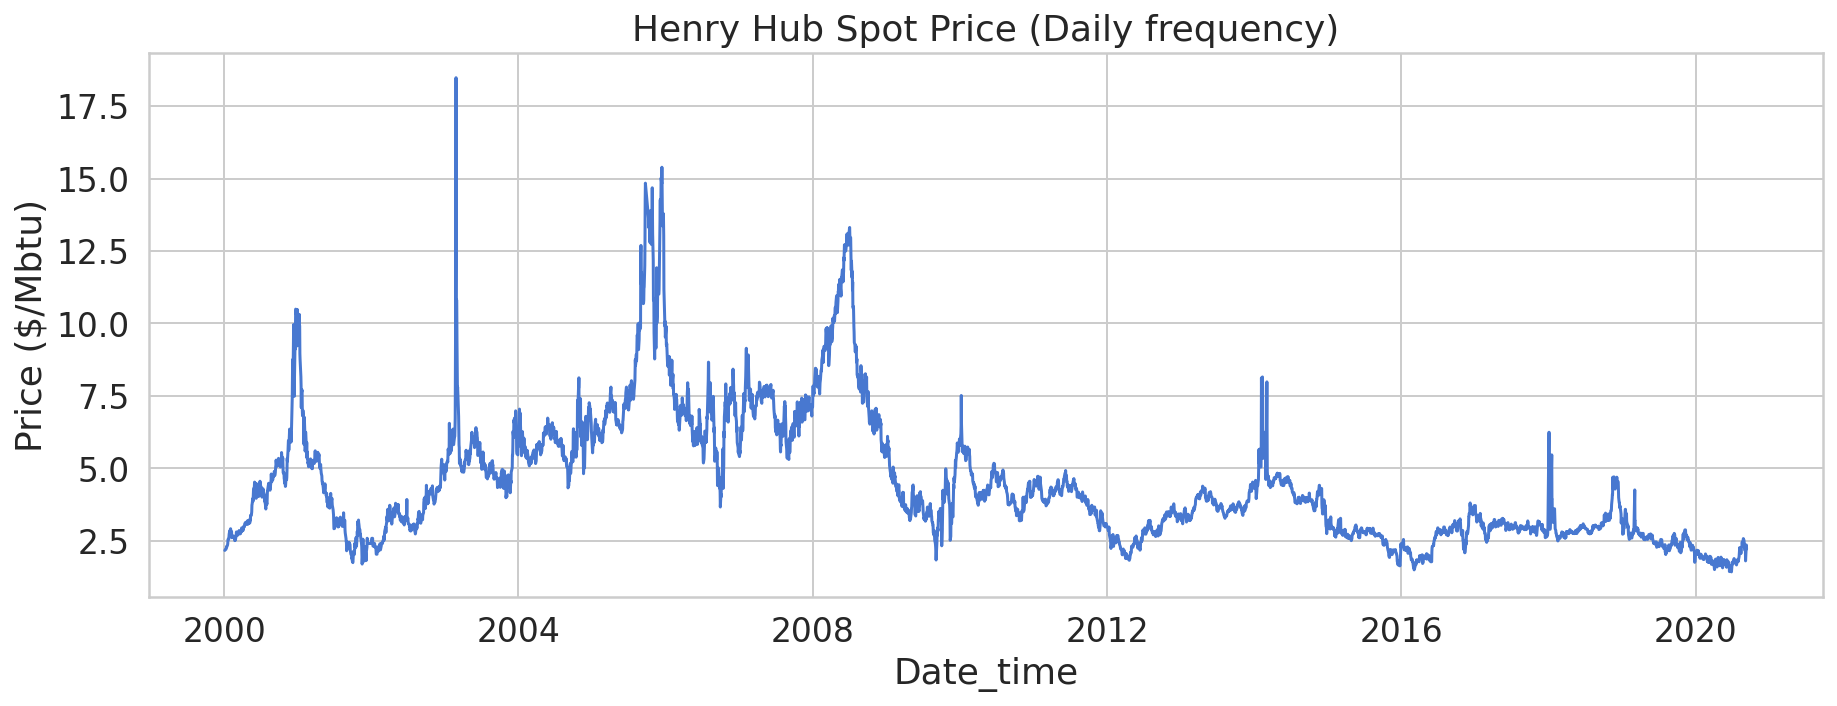

In [ ]:
print('Historical Spot price visualization:')
plt.figure(figsize = (15,5))
plt.plot(spot_price)
plt.title('Henry Hub Spot Price (Daily frequency)')
plt.xlabel ('Date_time')
plt.ylabel ('Price ($/Mbtu)')
plt.show()

In [ ]:
print('Missing values:', spot_price.isnull().sum()) # checking missing values
spot_price = spot_price.dropna() # dropping missing valies
print('....Dropped Missing value row....')
print('Rechecking Missing values:', spot_price.isnull().sum()) # checking missing values

Missing values: price    1
dtype: int64
....Dropped Missing value row....
Rechecking Missing values: price    0
dtype: int64


In [ ]:
spot_price.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,5216.0,4.45351,2.205964,1.42,2.87,3.86,5.59,18.48


Box plot visualization:


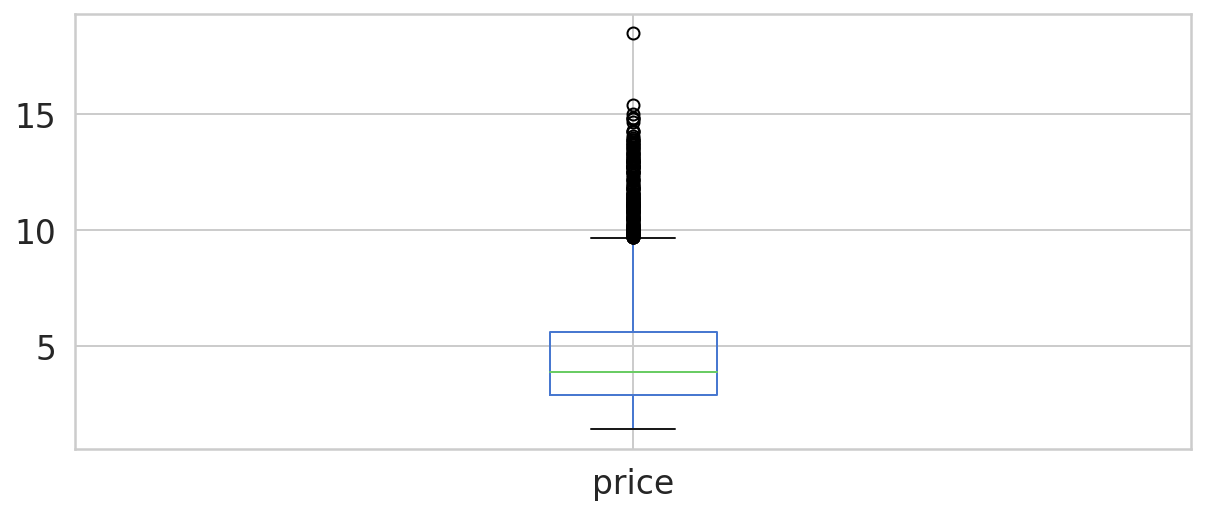

In [ ]:
# Generate a Boxplot
print('Box plot visualization:')
spot_price.plot(kind='box', figsize = (10,4))
plt.show()

Notice the circles at the top. we instantly get a feeling of something wrong in there as it deviates hugely from the rest of the data. Now, you decide to look at the data from another visual perspective i.e. in terms of histograms.

Histogram visualization:


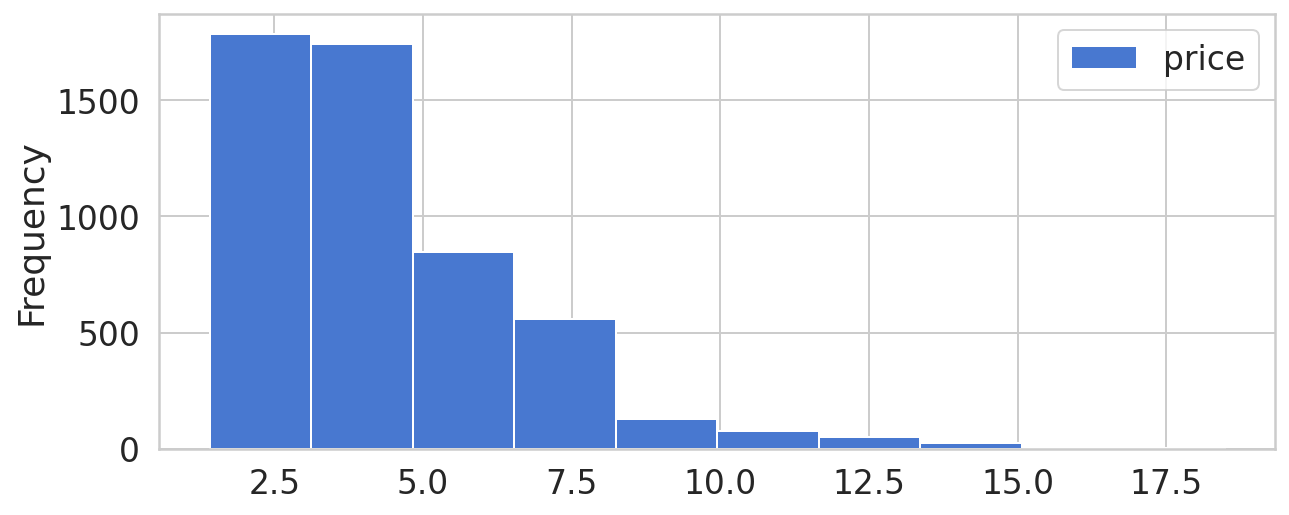

In [ ]:
# Generate a Histogram plot
print('Histogram visualization:')
spot_price.plot(kind='hist', figsize = (10,4) )
plt.show()

In [ ]:
# Minimum and maximum prices
print('Minimum ' + str(spot_price.min()))
print('Maximum ' + str(spot_price.max()))

Minimum price    1.42
dtype: float64
Maximum price    18.48
dtype: float64


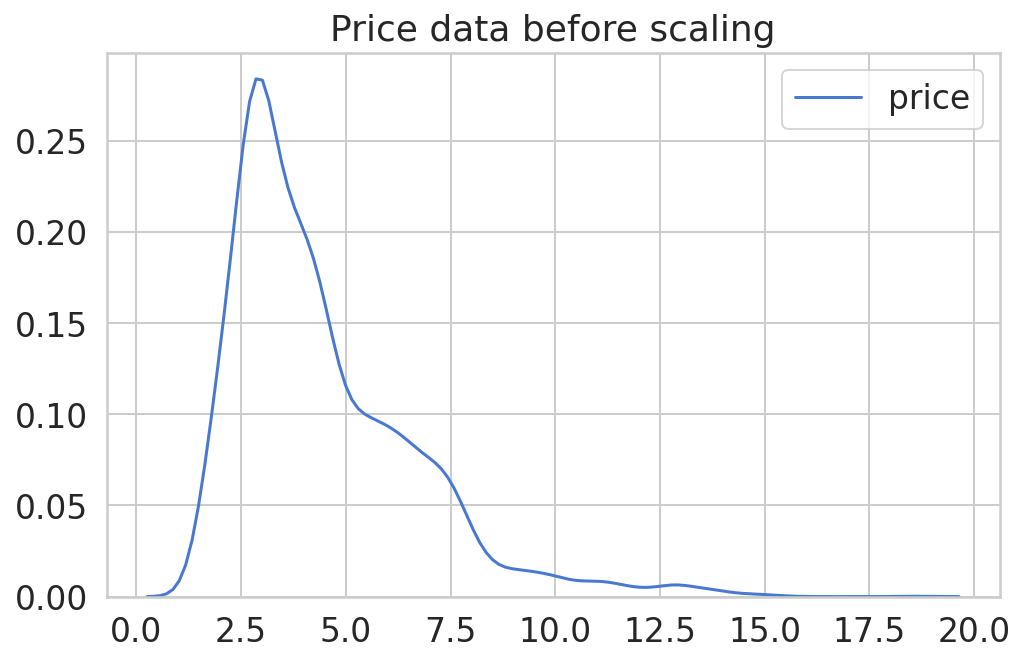

In [ ]:
fig, ax1 = plt.subplots(ncols=1, figsize = (8,5))
ax1.set_title('Price data before scaling')
sns.kdeplot(spot_price['price'], ax=ax1)
plt.show()

In [ ]:
The data points have a minimum of 1.42 and maximum of 18.48, which is a wide range.
We can use scaling to normalize the data.

### Preprocessing
We’ll use 95% of the data and train our model on it:

In [ ]:
train_size = int(len(spot_price) * 0.95)
test_size = len(spot_price) - train_size
train, test = spot_price.iloc[0:train_size], spot_price.iloc[train_size:len(spot_price)]
print('Train shape:',train.shape)
print('Test shape:', test.shape)

Train shape: (4955, 1)
Test shape: (261, 1)


Next, we’ll rescale the data using the training data and apply the same transformation to the test
data:

In [ ]:
from sklearn.preprocessing import RobustScaler

robust = RobustScaler(quantile_range=(25, 75)).fit(train[['price']])

train['price'] = robust.transform(train[['price']])
test['price'] = robust.transform(test[['price']])

Finally, we’ll split the data into subsequences. Here’s the little helper function for that:

In [ ]:
def create_dataset(X, y, time_steps=1):
  a, b = [], []
  for i in range(len(X) - time_steps):
    v = X.iloc[i:(i + time_steps)].values
    a.append(v)
    b.append(y.iloc[i + time_steps])
  return np.array(a), np.array(b)

We’ll create sequences with 30 days worth of historical data:

In [ ]:
n_steps = 30

# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train[['price']], train['price'], n_steps)
X_test, y_test = create_dataset(test[['price']], test['price'], n_steps)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (4925, 30, 1)
X_test shape: (231, 30, 1)


## LSTM Autoencoder in Keras
Our Autoencoder should take a sequence as input and outputs a sequence of the same shape. 

There are a total of 5219 data points in the sequence and our goal is to find anomalies. This means we are trying to find out when data points are abnormal. If we can predict a data point at time t based on the historical data until t-1, then we have a way of looking at an expected value compared to an actual value to see if we are within the expected range of values for time t. 

We can comparey_pred with the actual value (y_test). The difference
between y_pred and y_test gives the error, and when we get the errors of all the points in the sequence, we end up with a distribution of just errors.

To accomplish this, we will use a sequential model using Keras. The model consists of a LSTM layer and a dense layer. The LSTM layer takes as input the time series data and learns how to learn the values with respect to time. The next layer is the dense layer (fully connected layer). The dense layer takes as input the output from the LSTM layer, and transforms it into a fully connected manner. 

We also use the adam optimizer and the mae as the loss function.

In [ ]:
units = 64
dropout = 0.20
optimizer = 'adam'
loss = 'mae'
epochs = 20


model = keras.Sequential()
model.add(keras.layers.LSTM(units=units, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(rate=dropout))
model.add(keras.layers.RepeatVector(n=X_train.shape[1])) # RepeatVector layer simply repeats the input n times. 
model.add(keras.layers.LSTM(units=units, return_sequences=True)) # Adding return_sequences=True in LSTM layer makes it return the sequence.
model.add(keras.layers.Dropout(rate=dropout))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2]))) 
# TimeDistributed layer creates a vector with a length of the number of outputs from the previous layer.
model.compile(loss= loss, optimizer=optimizer)

history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_split=0.1, shuffle=False)

Epoch 1/20
139/139 [==============================] - 2s 11ms/step - loss: 0.1760 - val_loss: 0.0770
Epoch 2/20
139/139 [==============================] - 1s 6ms/step - loss: 0.1211 - val_loss: 0.0699
Epoch 3/20
139/139 [==============================] - 1s 6ms/step - loss: 0.1093 - val_loss: 0.0659
Epoch 4/20
139/139 [==============================] - 1s 6ms/step - loss: 0.1008 - val_loss: 0.0559
Epoch 5/20
139/139 [==============================] - 1s 6ms/step - loss: 0.0925 - val_loss: 0.0590
Epoch 6/20
139/139 [==============================] - 1s 6ms/step - loss: 0.0894 - val_loss: 0.0580
Epoch 7/20
139/139 [==============================] - 1s 6ms/step - loss: 0.0879 - val_loss: 0.0529
Epoch 8/20
139/139 [==============================] - 1s 6ms/step - loss: 0.0835 - val_loss: 0.0532
Epoch 9/20
139/139 [==============================] - 1s 6ms/step - loss: 0.0834 - val_loss: 0.0540
Epoch 10/20
139/139 [==============================] - 1s 6ms/step - loss: 0.0806 - val_loss: 0.045

In [ ]:
history.history.keys() # finding the keys to use for plotting

dict_keys(['loss', 'val_loss'])

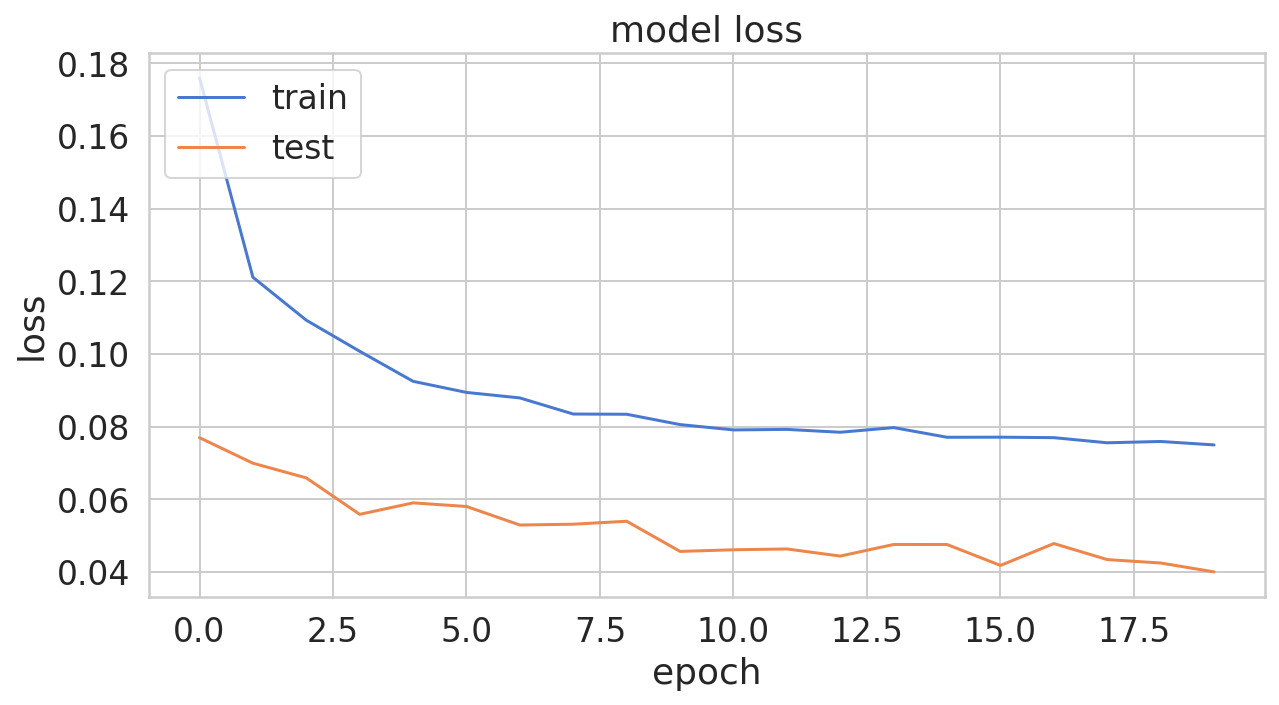

In [ ]:
# history for loss
plt.figure(figsize = (10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluation
We’ve trained our model for 10 epochs with less than 8k examples. Here are the results. Once the model is trained, you can predict a test dataset that is split into subsequences of the same length (time_steps) as the training datasets. Once this is done, you can then compute the mae. Let’s start with calculating the Mean Absolute Error (MAE) on the training data:

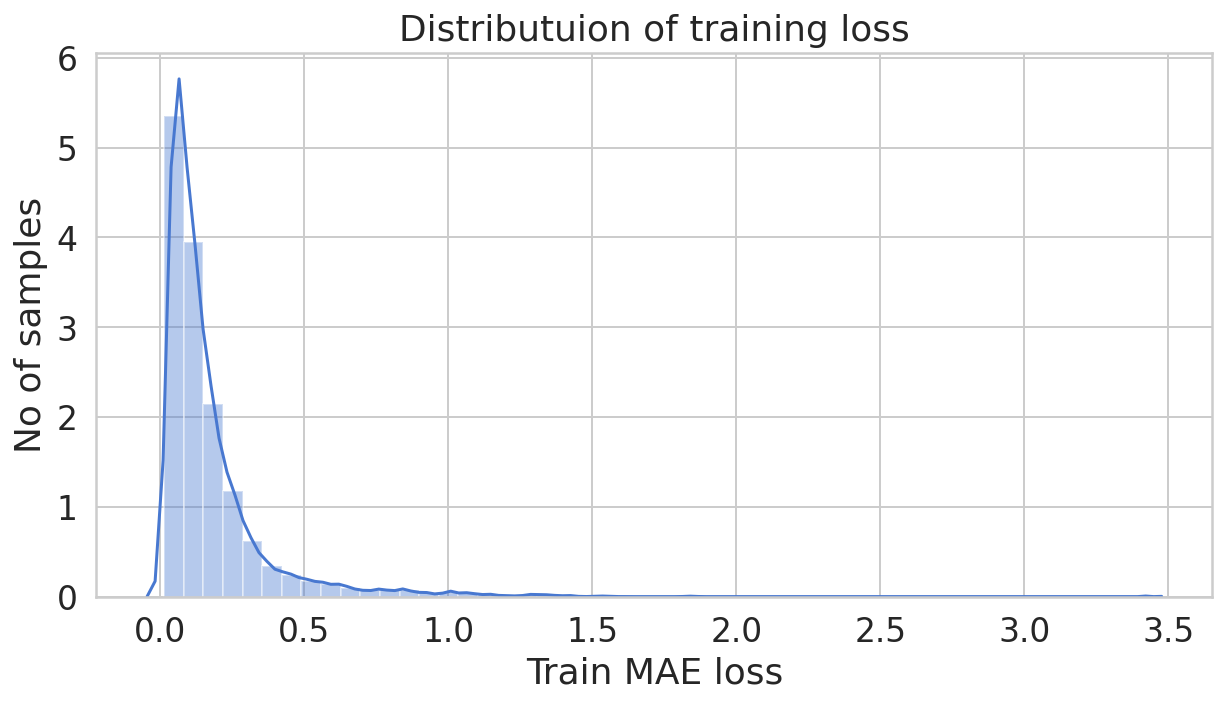

In [ ]:
train_pred = model.predict(X_train)
train_loss = (np.mean(np.abs(train_pred - X_train), axis=1))

plt.figure(figsize = (10,5))
sns.distplot(train_loss, bins=50, kde=True);
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.title('Distributuion of training loss')
plt.show()

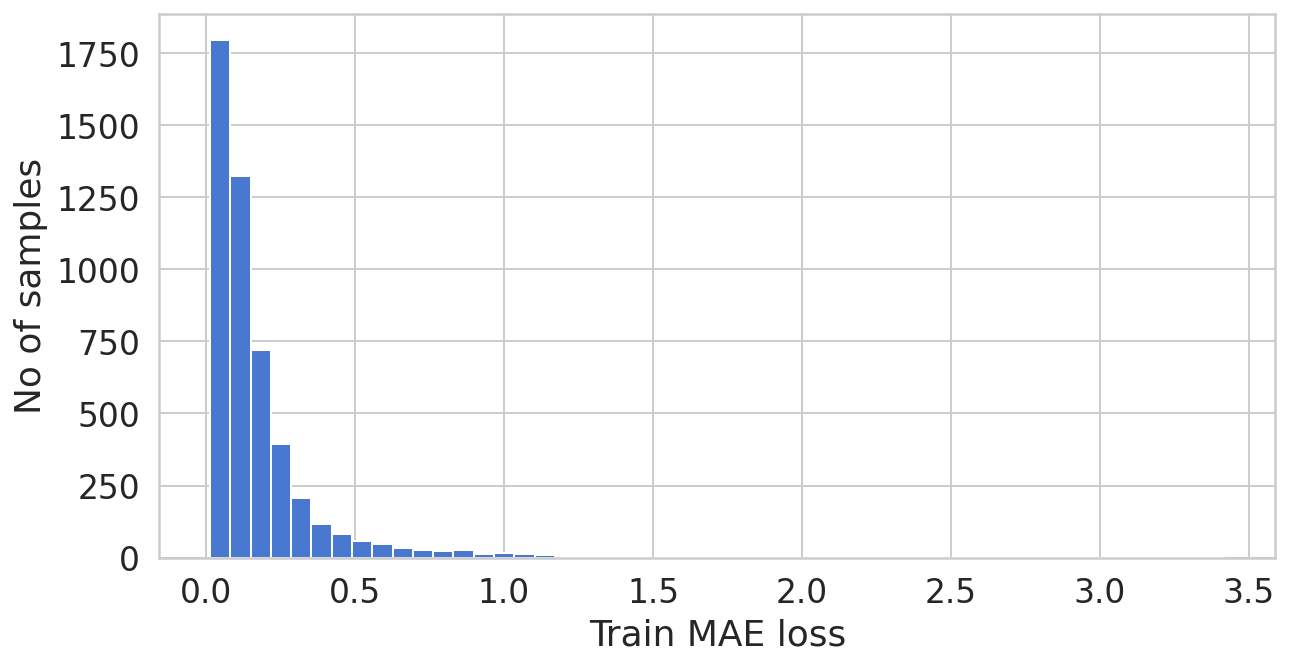

Reconstruction error threshold:  3.4177961145622144


In [ ]:
# Get train MAE loss.
train_pred = model.predict(X_train)
train_loss = np.mean(np.abs(train_pred - X_train), axis=1)

plt.figure(figsize = (10,5))
plt.hist(train_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_loss)
print("Reconstruction error threshold: ", threshold)

### Compare recontruction
Let's see how our model has recontructed the first sample. 

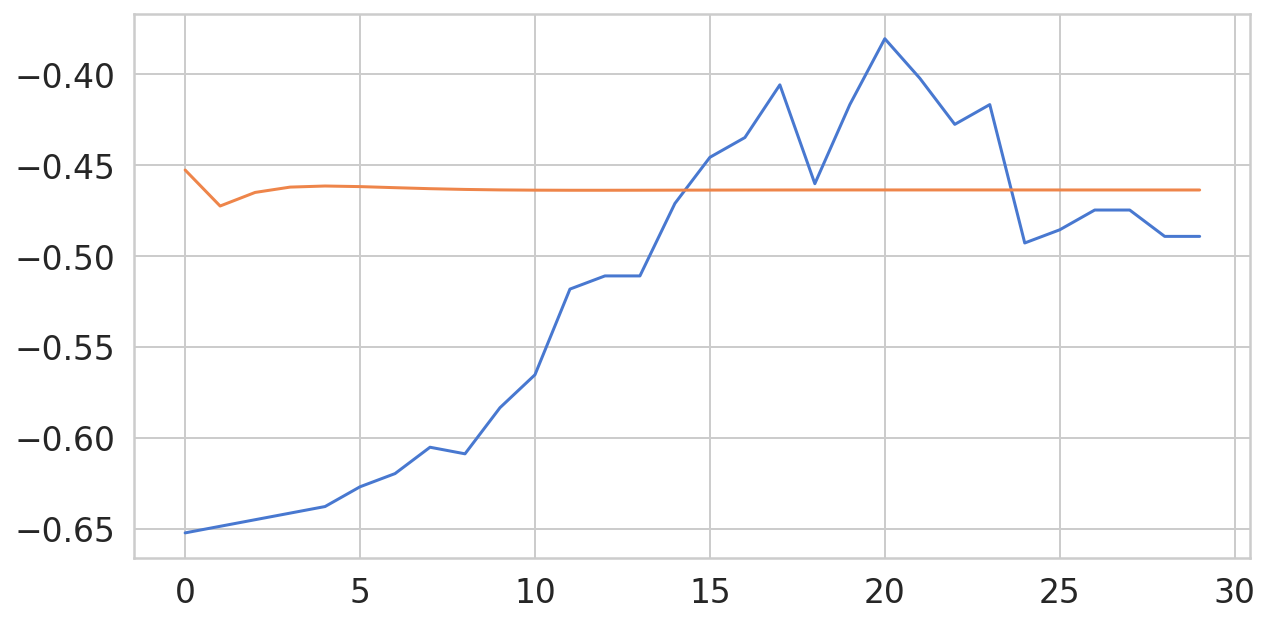

In [ ]:
# Checking how the first sequence is learnt
plt.figure(figsize = (10,5))
plt.plot(X_train[0])
plt.plot(train_pred[0])
plt.show()

We’ll pick a threshold of 0.15, as not much of the loss is larger than that. When the error is larger than that, we’ll declare that example an anomaly:


In [ ]:
import math
from sklearn.metrics import mean_squared_error
from pandas import DataFrame

# MAE on the test data:
y_pred = model.predict(X_test)
print('Predict shape:', y_pred.shape); print();
mae = np.mean(np.abs(y_pred - X_test), axis=1)

# reshaping prediction
pred = y_pred.reshape((y_pred.shape[0] * y_pred.shape[1]), y_pred.shape[2])
print('Prediction:', pred.shape); print();

print('Test data shape:', X_test.shape); print();

# reshaping test data
X_test = X_test.reshape((X_test.shape[0] * X_test.shape[1]), X_test.shape[2])
print('Test data:', X_test.shape); print();

# error computation
errors = X_test - pred
print('Errors:', errors.shape); print();

# rmse on test data
RMSE = math.sqrt(mean_squared_error(X_test, pred_reshape))
print('Test RMSE: %.3f' % RMSE);

Predict shape: (231, 30, 1)

Prediction: (6930, 1)

Test data shape: (231, 30, 1)

Test data: (6930, 1)

Errors: (6930, 1)

Test RMSE: 0.099


In [ ]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))


RMSE is 0.099, which is low, and this is also evident from the low loss from the training phase after 20 epochs: loss: 0.0750 - val_loss: 0.0403

In [ ]:
dist = np.linalg.norm(X_test - pred, axis=1)
"""
Sorting the scores/diffs and using a 0.80 as cutoff value to pick the threshold
""" 
scores = dist.copy()
print('Score:', scores.shape)

scores.sort()
cut_off = int(0.80 * len(scores))
print('Cutoff value:', cut_off)

threshold = scores[cut_off]
print('Threshold value:', threshold)

Score: (6930,)
Cutoff value: 5544
Threshold value: 0.1182294107865598


You got 0.118 as the threshold; anything above is considered an anomaly.

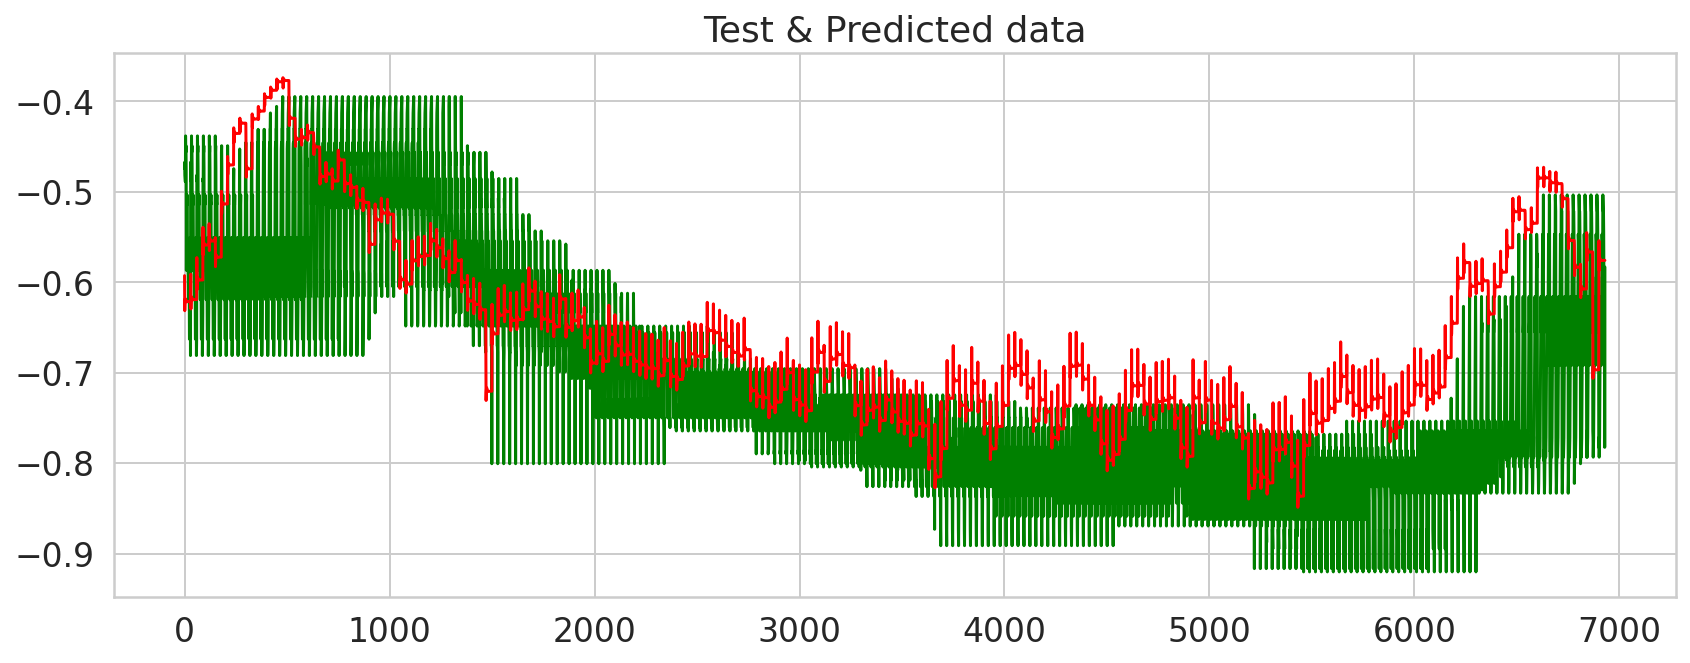

In [ ]:
plt.figure(figsize= (14,5))
plt.plot(X_test, color = 'green')
plt.plot(pred, color = 'red')
plt.title("Test & Predicted data")
plt.show()

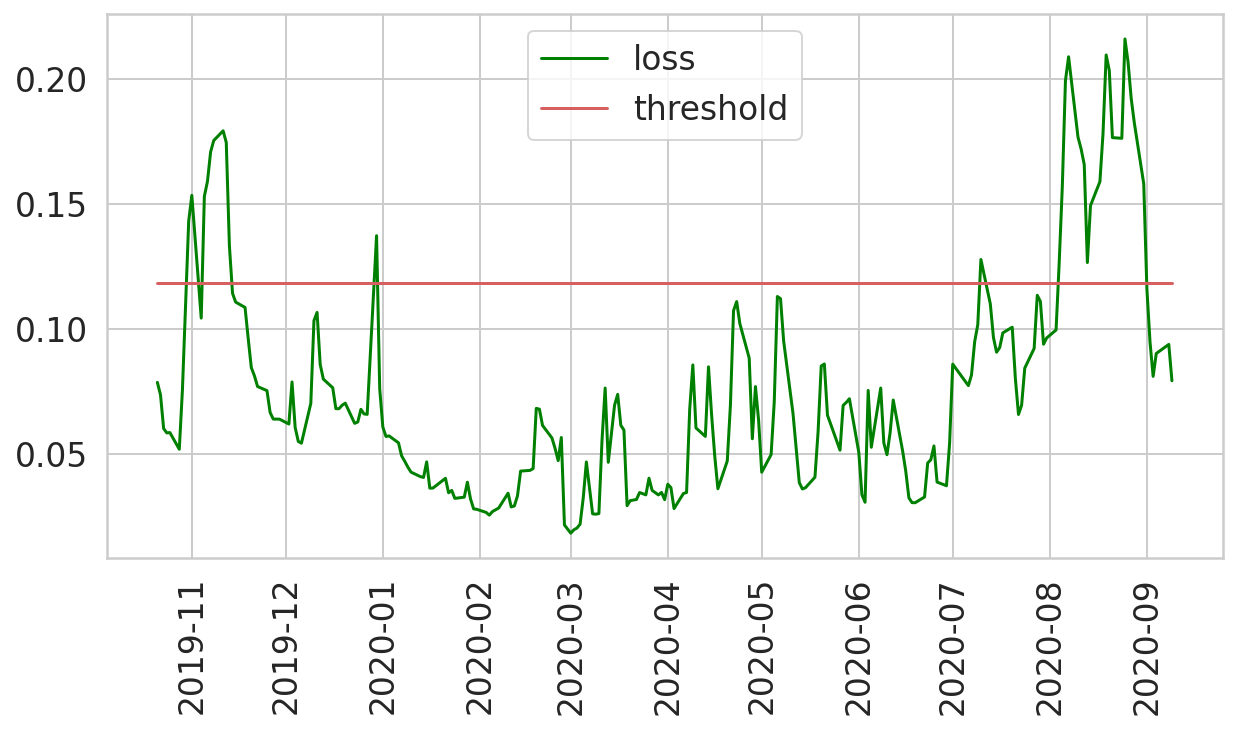

In [ ]:
score = DataFrame(index=test[n_steps:].index)
score['loss'] = mae
score['threshold'] = threshold
score['anomaly'] = score['loss'] > score['threshold']
score['price'] = test[TIME_STEPS:].price

plt.figure(figsize = (10,5))
plt.plot(score.index, score['loss'], color = 'green', label='loss')
plt.plot(score.index, score['threshold'], color = 'r', label='threshold')
plt.xticks(rotation=90)
plt.legend();

In [ ]:
anomalies = score[score['anomaly'] == True]
x = DataFrame(anomalies.price)
x = DataFrame(robust.inverse_transform(x))
x.index = anomalies.index
x.rename(columns = {0: 'inverse_price'}, inplace = True)
anomalies = anomalies.join(x, how = 'left')
anomalies = anomalies.drop(columns=['price'], axis=1)
anomalies.tail(10)

,loss,threshold,anomaly,inverse_price
Date,,,,
2020-08-18,0.178424,0.118229,True,2.45
2020-08-19,0.209752,0.118229,True,2.43
2020-08-20,0.203537,0.118229,True,2.35
2020-08-21,0.176636,0.118229,True,2.39
2020-08-24,0.176374,0.118229,True,2.57
2020-08-25,0.216156,0.118229,True,2.54
2020-08-26,0.206829,0.118229,True,2.52
2020-08-27,0.192255,0.118229,True,2.52
2020-08-28,0.182474,0.118229,True,2.46


In [ ]:
x = DataFrame(anomalies.price)
x = DataFrame(robust.inverse_transform(x))
x.index = anomalies.index
x.rename(columns = {0: 'inverse_price'}, inplace = True)
anomalies = anomalies.join(x, how = 'left')
anomalies = anomalies.drop(columns=['price'], axis=1)
anomalies.tail(10)

,loss,threshold,anomaly,inverse_price
Date,,,,
2020-08-18,0.178424,0.118229,True,2.45
2020-08-19,0.209752,0.118229,True,2.43
2020-08-20,0.203537,0.118229,True,2.35
2020-08-21,0.176636,0.118229,True,2.39
2020-08-24,0.176374,0.118229,True,2.57
2020-08-25,0.216156,0.118229,True,2.54
2020-08-26,0.206829,0.118229,True,2.52
2020-08-27,0.192255,0.118229,True,2.52
2020-08-28,0.182474,0.118229,True,2.46


In [ ]:
test[n_steps:].index

DatetimeIndex(['2019-10-21', '2019-10-22', '2019-10-23', '2019-10-24',
               '2019-10-25', '2019-10-28', '2019-10-29', '2019-10-30',
               '2019-10-31', '2019-11-01',
               ...
               '2020-08-26', '2020-08-27', '2020-08-28', '2020-08-31',
               '2020-09-01', '2020-09-02', '2020-09-03', '2020-09-04',
               '2020-09-08', '2020-09-09'],
              dtype='datetime64[ns]', name='Date', length=231, freq=None)

In [ ]:
test_inv = DataFrame(robust.inverse_transform(test[n_steps:]))
test_inv.index = test[n_steps:].index
test_inv.rename(columns = {0: 'price'}, inplace = True)
test_inv

,price
Date,
2019-10-21,2.13
2019-10-22,2.21
2019-10-23,2.34
2019-10-24,2.33
2019-10-25,2.26
...,...
2020-09-02,2.15
2020-09-03,2.32
2020-09-04,1.80


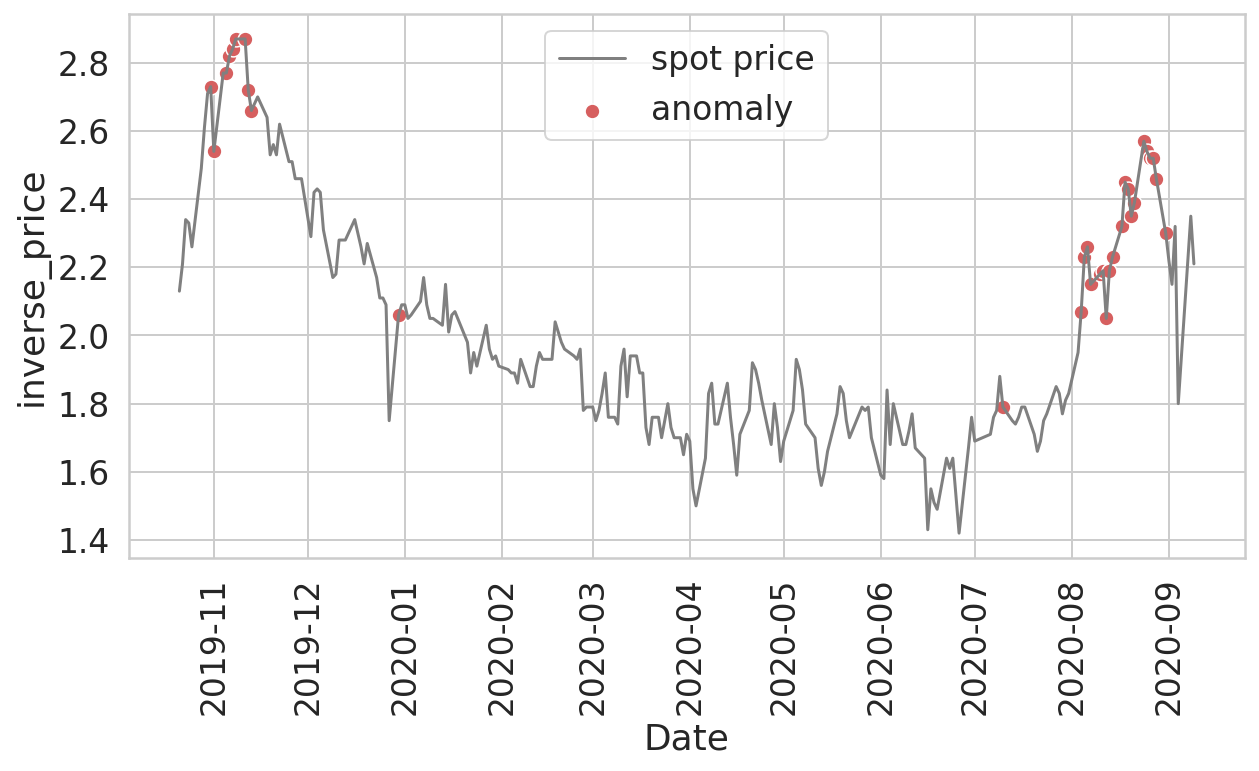

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(test_inv.index, test_inv.price, color = 'gray', label='spot price');
sns.scatterplot(anomalies.index, anomalies['inverse_price'], color=sns.color_palette()[3], s=55, label='anomaly')
plt.xticks(rotation=90)
plt.legend(loc='upper center');

The red dots (anomalies) are covering most of the
points with abrupt changes to the spot price.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f'Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f'Significance Level = {signif}')
    print(f'Test Statistic = {output["test_statistic"]}')
    print(f'No. Lags Chosen = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")


# ADF test 
for name, column in spot_price.iteritems():
  adfuller_test(column, name = column.name)

Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level = 0.05
Test Statistic = -2.8589
No. Lags Chosen = 32
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0503. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


In [ ]:
"""
Extract the values and apply log transform to stabilize the variance in the data or 
to make it stationary before feeding it to the model.
"""
n_steps = 60
train, test = spot_price[0:-n_steps], spot_price[-n_steps:] # splitting data in train/test set; keeping 60 days data for validation
train_log, test_log = np.log10(train).diff().dropna(), np.log10(test).diff().dropna() # log transformation

In [ ]:
# ADF test 
for name, column in train_log.iteritems():
  adfuller_test(column, name = column.name)

Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level = 0.05
Test Statistic = -14.3591
No. Lags Chosen = 31
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


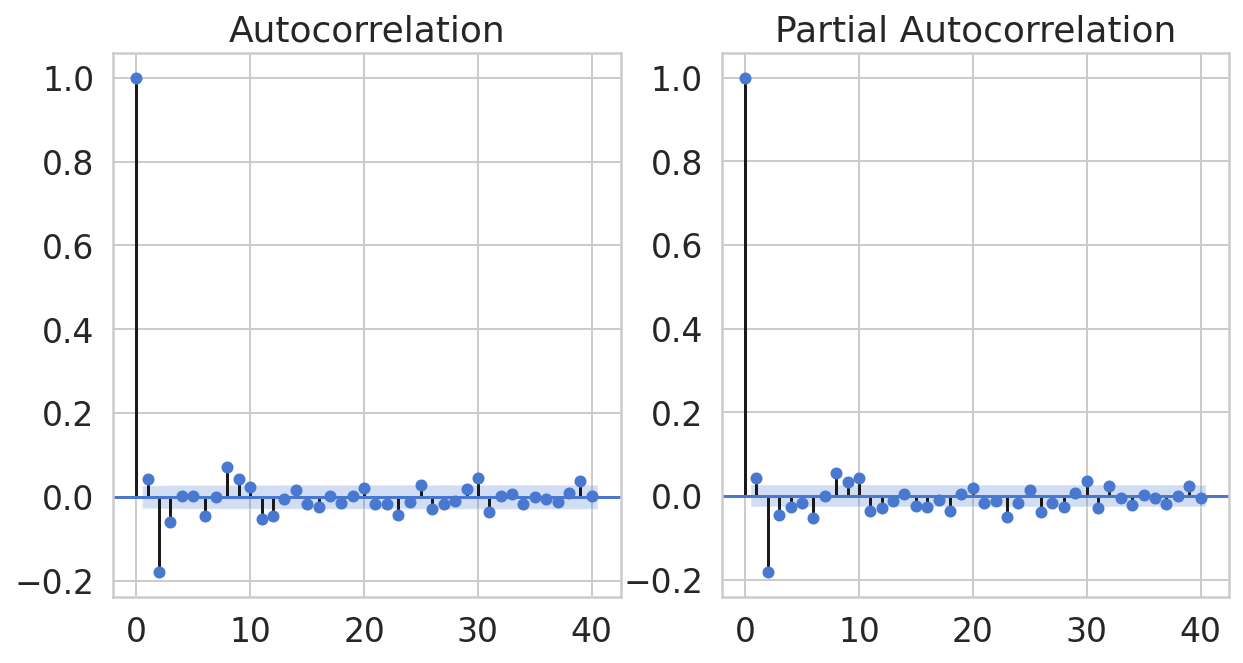

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10,5))
sm.graphics.tsa.plot_acf(train_log.squeeze(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_log.squeeze(), lags=40, ax=ax[1])
plt.show()

## Parameter Estimation

After the log transformation and differencing we no longer have a trend but the seasonality is still present and irregular. We can use the ACF and PACF plots to determine the correct parameters for our SARIMA model.

First, looking at the ACF we have a m value of 1, given that our greatest autocorrelation is at lag number 1, which makes since given our original plot and that this is daily data.

Given that m is positive that would indicate that P = 1, and Q = 0. Looking at the ACF and PACF plots both have their first significant lag at 1. So p = 1, and q = 1. Because we differenced the series d will also be 1. So we have parameters of: SARIMA(1,1,1)(1,0,0)[1]

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

In [ ]:
!pip install pmdarima

In [ ]:
from pmdarima import auto_arima

# Lets find p and q parameters using auto_arima and specify d as 1 for first order differencing and seasonality as 12 for yearly seasonality.

stepwise_model = auto_arima(train_log.values, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model)

At a time we predict the next data point and we loop through train data to predict the next data and add the next data point after prediction for further forecasting.

This is like a moving window daily level data(For eg: Previous 90 points are used to predict the next point at any given time).

Convert the predicted data back to scale by power 10 transform and plot the results.

In [ ]:
order = (1,1,1)
seasonal_order = (1,0,0,12)
max_lags = 5
model = sm.tsa.SARIMAX(train_log.values, order=order, seasonal_order=seasonal_order,
                       enforce_stationarity=False,enforce_invertibility=False,
                       mle_regression = True, maxlags = max_lags)
model_fit = model.fit(disp = False)

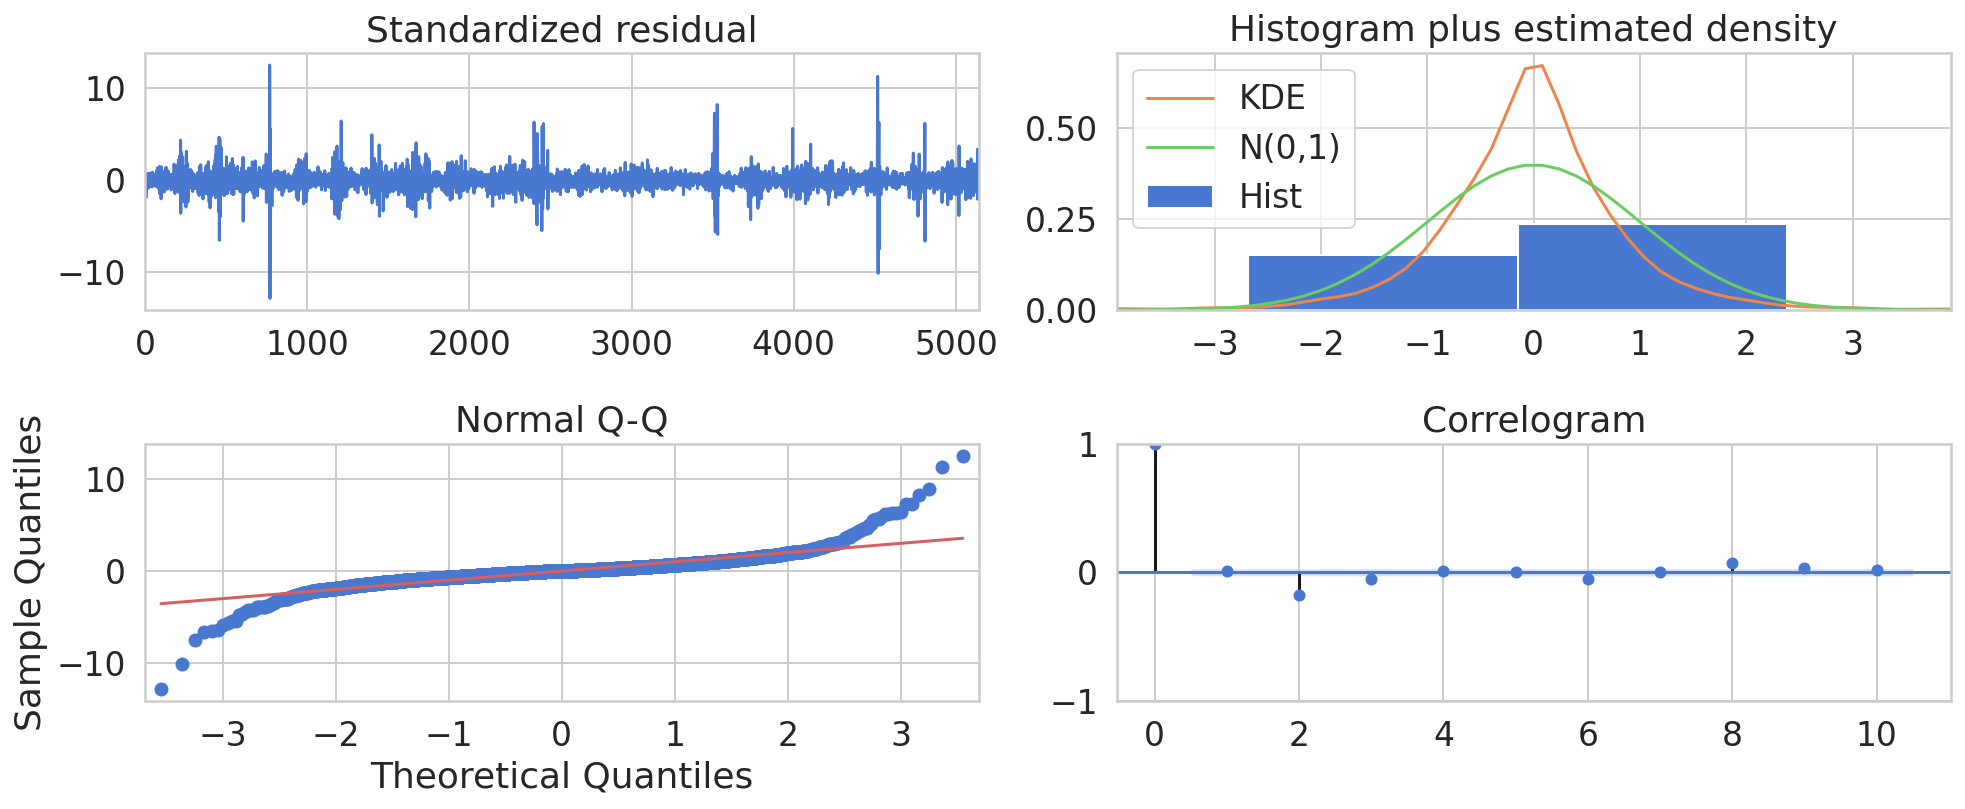

In [ ]:
model_fit.plot_diagnostics(figsize=(14, 6))
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

fcast_len = len(test)
fcast = model_fit.forecast(fcast_len)

mse = mean_squared_error(test, fcast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, fcast)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 3.934295007488607
Root Mean Squared Error: 1.9835057366916304
Mean Absolute Error: 1.9568856750411079


In [ ]:
# converting fcast values to original scale
last_value = test['price'].iloc[-1]
fcast = (np.exp(fcast.cumsum())*last_value)
fcast = DataFrame(fcast)
fcast.index = test.index
fcast.rename(columns = {0: 'Forecast'}, inplace = True)
fcast.tail()

,Forecast
Date,
2020-09-02,2.183069
2020-09-03,2.182589
2020-09-04,2.182109
2020-09-08,2.181629
2020-09-09,2.181149


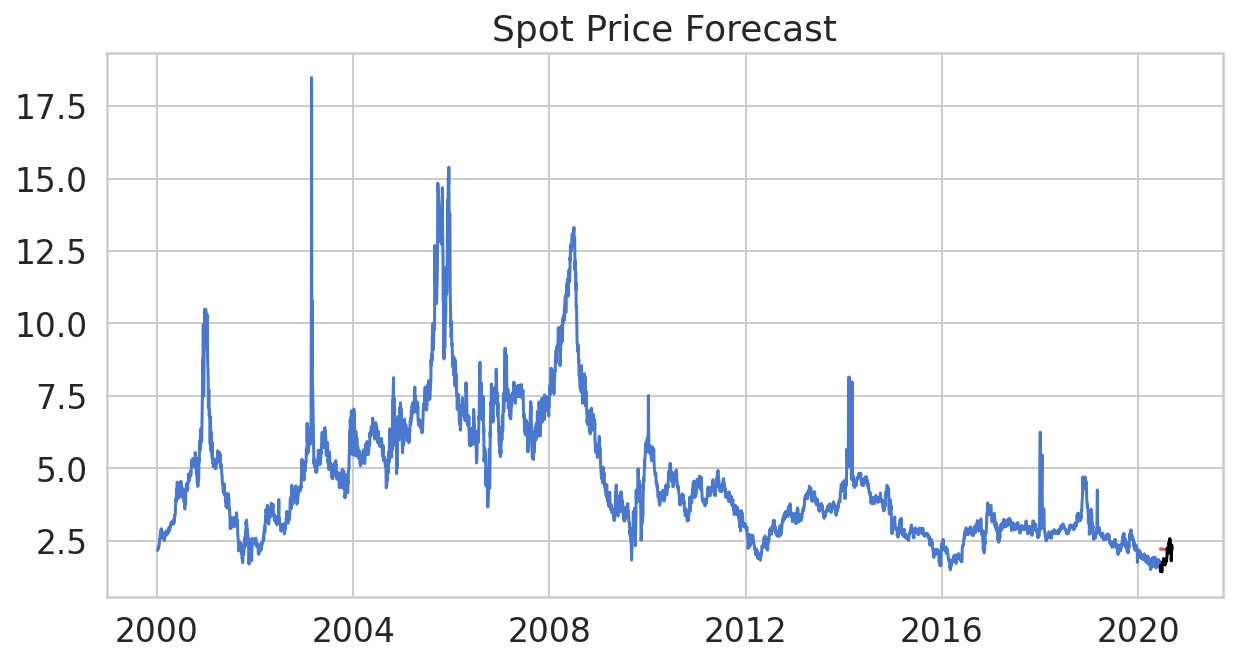

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Spot Price Forecast', fontsize=18)
plt.plot(train, label='Train')
plt.plot(fcast, color = 'r', label='Forecast')
plt.plot(test, color = 'black', label='Test')
plt.show()

In [ ]:
from pandas import concat
combine = fcast.join(test, how='left')
combine = combine.round(decimals=3)
combine.tail(10)

,Forecast,price
Date,,
2020-08-26,2.185,2.52
2020-08-27,2.185,2.52
2020-08-28,2.185,2.46
2020-08-31,2.184,2.30
2020-09-01,2.184,2.22
2020-09-02,2.183,2.15
2020-09-03,2.183,2.32
2020-09-04,2.182,1.80
2020-09-08,2.182,2.35
